In [2]:
import os, random, natsort
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense, LeakyReLU, ReLU, Dropout, PReLU
from keras.backend import clear_session
from keras.models import Model
from keras.optimizers import Adam, Nadam

import tensorflow as tf
from keras.layers import Input, Dropout, Dense, BatchNormalization
from keras.layers import Conv1D, Flatten, MaxPooling1D
from tensorflow.keras.layers import PReLU
import tensorflow_addons as tfa
from tensorflow.python.client import device_lib

from keras.regularizers import L2

In [5]:
def check_tensorflow_gpu():
    sys_info = tf.sysconfig.get_build_info()
    cuda_version, cudnn_version = sys_info['cuda_version'], sys_info['cudnn_version']
    num_gpu_avail = len(tf.config.experimental.list_physical_devices('GPU'))
    gpu_name = device_lib.list_local_devices()[1].physical_device_desc[17:40]
    print('Tensorflow built with CUDA?',  tf.test.is_built_with_cuda())
    print("TF: {} | CUDA: {} | cuDNN: {}".format(tf.__version__, cuda_version, cudnn_version))
    print('# GPU available: {} ({})'.format(num_gpu_avail, gpu_name))
check_tensorflow_gpu()

Tensorflow built with CUDA? True
TF: 2.13.0 | CUDA: 11.8 | cuDNN: 8
# GPU available: 1 (NVIDIA GeForce RTX 3080)


2023-11-22 13:20:37.714488: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 13:20:37.714678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 13:20:37.714727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 13:20:37.714973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 13:20:37.714985: I tensorflow/core/co

In [6]:
data = pd.read_csv('Full_Inputs_LSTM_OIPM.csv')
data = data.drop(['Unnamed: 10', 'Unnamed: 11'], axis=1)
OIPM = np.array(data.pop('OIPM_1')).reshape(-1,1)
scaler_OIPM = MinMaxScaler(feature_range=(0,1))
scaler_OIPM.fit(OIPM)
OIPM_norm = scaler_OIPM.transform(OIPM)
OIPM_norm = OIPM_norm.reshape(-1, 101)

In [7]:
scaler_data = MinMaxScaler(feature_range=(0,1))
scaler_data.fit(data)
data_norm = scaler_data.transform(data)

In [8]:
num_sequences = data_norm.shape[0] // 101
data_norm = data_norm.reshape(-1, 101, 9)

In [9]:
labels = np.any(OIPM_norm != 0, axis=1)
labels = labels.astype(int)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(data_norm, labels, test_size=0.2)

In [10]:
def make_cnn_model():
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(101, 9)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    return model

cnn_model = make_cnn_model()
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = cnn_model.fit(X_train_clf, y_train_clf, 
                    epochs=100,
                    batch_size=128, 
                    validation_split=0.2, 
                    shuffle=True, 
                    verbose=0)

preds = (cnn_model.predict(X_test_clf) > 0.5).astype("int32")
preds = np.array(preds)

2023-11-22 13:20:44.694922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 13:20:44.695054: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 13:20:44.695101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 13:20:44.695321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 13:20:44.695333: I tensorflow/core/co

19/19 [==============================] - 0s 5ms/step


In [11]:
mask_class_0 = preds == 0
mask_class_1 = preds == 1

P_0 = preds[mask_class_0]
P_1 = preds[mask_class_1]
print(f"P_0 shape: {P_0.shape}")
print(f"P_1 shape: {P_1.shape}")

labels_all = np.any(OIPM_norm != 0, axis=1)
labels_all = labels_all.astype(int) 

P_0 shape: (388,)
P_1 shape: (212,)


94/94 [==============================] - 0s 2ms/step
P_0_all shape: (2113, 101, 9)
P_1_all shape: (887, 101, 9)


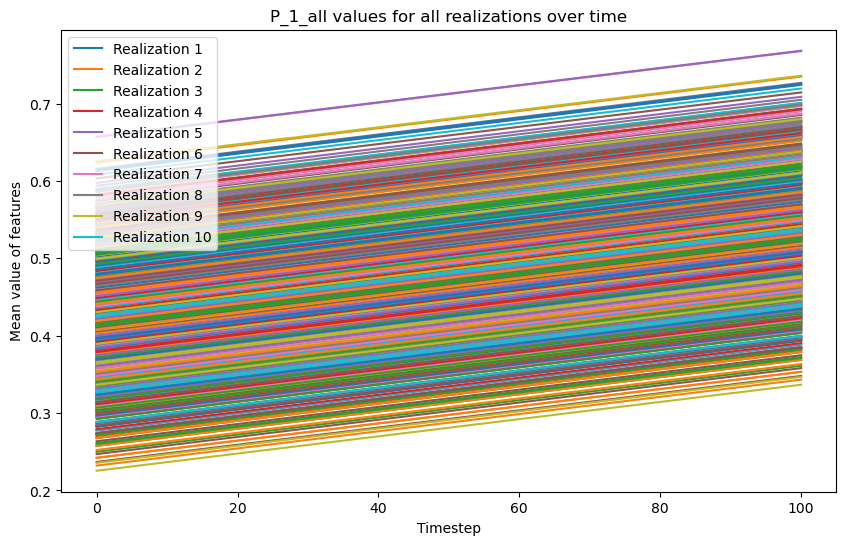

In [12]:
history = cnn_model.fit(data_norm, labels_all, epochs=100, batch_size=128, shuffle=True, verbose=0)
preds_all = (cnn_model.predict(data_norm) > 0.5).astype("int32")

mask_class_0_all = preds_all == 0
mask_class_1_all = preds_all == 1

P_0_all = data_norm[mask_class_0_all.squeeze()]
P_1_all = data_norm[mask_class_1_all.squeeze()]
print(f"P_0_all shape: {P_0_all.shape}")
print(f"P_1_all shape: {P_1_all.shape}")

P_1_all_mean = P_1_all.mean(axis=-1)

plt.figure(figsize=(10,6))
for i in range(P_1_all_mean.shape[0]):
    plt.plot(P_1_all_mean[i, :], label=f'Realization {i+1}' if i < 10 else None)
plt.xlabel('Timestep'); plt.ylabel('Mean value of features')
plt.title('P_1_all values for all realizations over time')
plt.legend()
plt.show()

In [13]:
preds_all = (cnn_model.predict(data_norm) > 0.5).astype("int32")

mask_class_0_all = preds_all == 0
mask_class_1_all = preds_all == 1

OIPM_norm_1 = OIPM_norm[mask_class_1_all.squeeze()]
data_norm_1 = data_norm[mask_class_1_all.squeeze()]
print(f"data_norm_1 shape: {data_norm_1.shape}")
print(f"OIPM_norm_1 shape: {OIPM_norm_1.shape}")


94/94 [==============================] - 0s 2ms/step
data_norm_1 shape: (887, 101, 9)
OIPM_norm_1 shape: (887, 101)


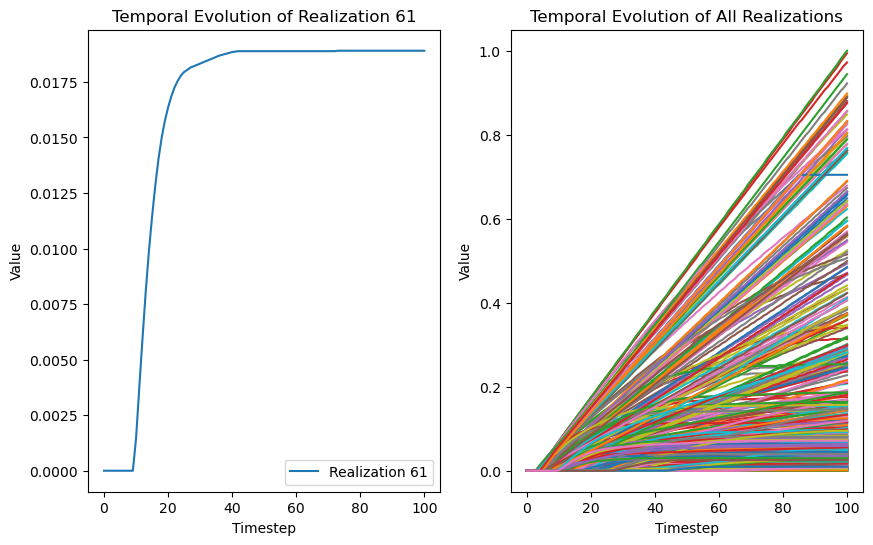

In [14]:
realization_index = 60

plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot(OIPM_norm_1[realization_index, :], label=f'Realization {realization_index+1}')
plt.xlabel('Timestep'); plt.ylabel('Value')
plt.title(f'Temporal Evolution of Realization {realization_index+1}')
plt.legend()

plt.subplot(122)
for i in range(OIPM_norm_1.shape[0]):
    plt.plot(OIPM_norm_1[i, :], label=f'Realization {i+1}')
plt.xlabel('Timestep'); plt.ylabel('Value')
plt.title('Temporal Evolution of All Realizations')
plt.show()

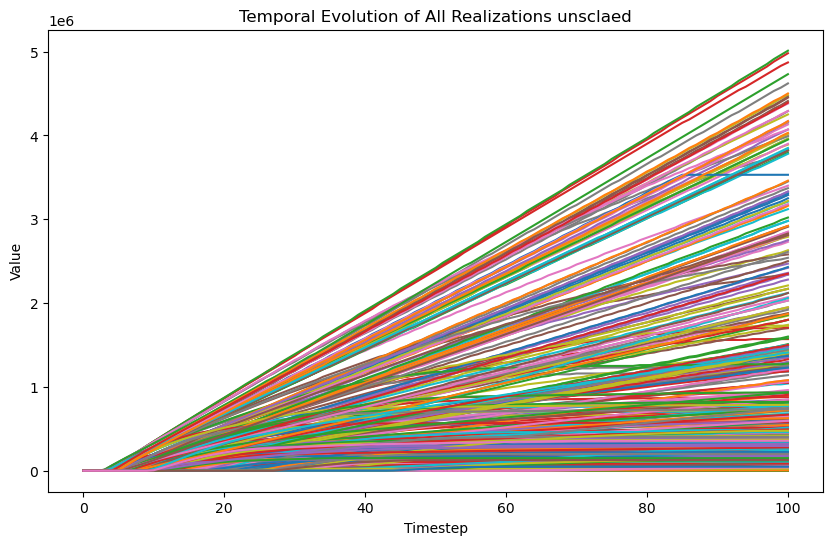

In [15]:
data_1 = data_norm_1.reshape(-1, data_norm_1.shape[-1])
data_1 = scaler_data.inverse_transform(data_1)
data_1 = data_1.reshape(data_norm_1.shape)

OIPM_1 = OIPM_norm_1.reshape(-1, 1)
OIPM_1 = scaler_OIPM.inverse_transform(OIPM_1)
OIPM_1 = OIPM_1.reshape(OIPM_norm_1.shape)

plt.figure(figsize=(10,6))
for i in range(OIPM_1.shape[0]):
    plt.plot(OIPM_1[i, :])
plt.xlabel('Timestep'); plt.ylabel('Value')
plt.title('Temporal Evolution of All Realizations unsclaed')
plt.show()

***

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data_norm_1, OIPM_norm_1, test_size=0.2)
print('X_train: {} | y_train: {}'.format(X_train.shape, y_train.shape))
print('X_test:  {} | y_test:  {}'.format(X_test.shape, y_test.shape))

X_train: (709, 101, 9) | y_train: (709, 101)
X_test:  (178, 101, 9) | y_test:  (178, 101)


In [39]:
def lstm_OIPM_model(reg=1e-5, drop=0.1):
    clear_session()
    def rnn_layer(inp, units):
        _ = GRU(units, kernel_regularizer=L2(reg), dropout=drop, return_sequences=True)(inp)
        _ = PReLU()(_)
        _ = BatchNormalization()(_)
        return _
    inp = Input(shape=(101,9))
    _ = rnn_layer(inp, 64)
    _ = rnn_layer(_,   128)
    out = rnn_layer(_, 1)
    return Model(inp, out)

In [40]:
model = lstm_OIPM_model()
model.compile(optimizer=Nadam(learning_rate=1e-3), loss='mse', metrics=['mse','mae'])
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=75,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=0)

y_train_pred = model.predict(X_train).squeeze()
y_test_pred  = model.predict(X_test).squeeze()

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse  = mean_squared_error(y_test, y_test_pred)
print('MSE: Train={:.3f} | Test={:.3f}'.format(train_mse, test_mse))

6/6 [==============================] - 0s 6ms/step
MSE: Train=0.014 | Test=0.013


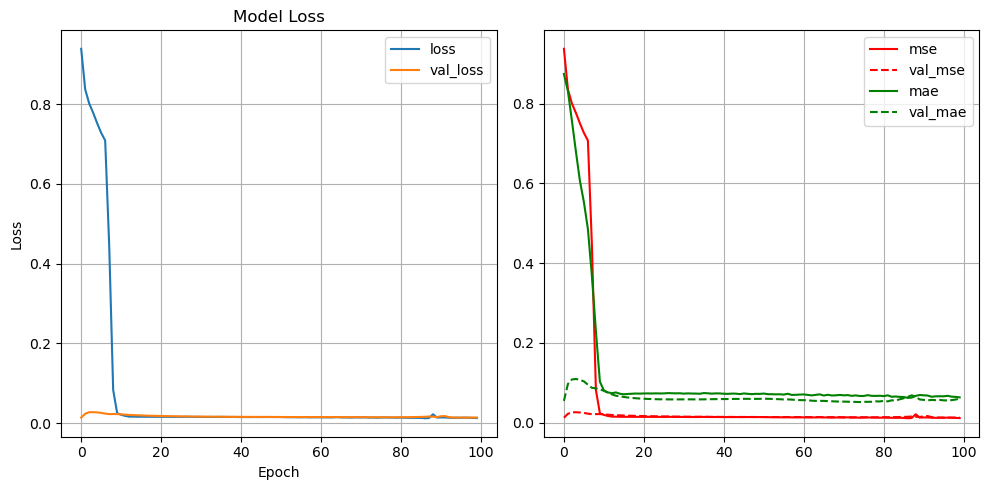

In [41]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(history.history['loss'], color='tab:blue', label='loss')
plt.plot(history.history['val_loss'], color='tab:orange', label='val_loss')
plt.title('Model Loss'); plt.legend(); plt.grid(True, which='both')
plt.ylabel('Loss'); plt.xlabel('Epoch')
plt.subplot(122)
plt.plot(history.history['mse'], 'r-', label='mse')
plt.plot(history.history['val_mse'], 'r--', label='val_mse')
plt.plot(history.history['mae'], 'g-', label='mae')
plt.plot(history.history['val_mae'], 'g--', label='val_mae')
plt.legend(); plt.grid(True, which='both')
plt.tight_layout(); plt.show()

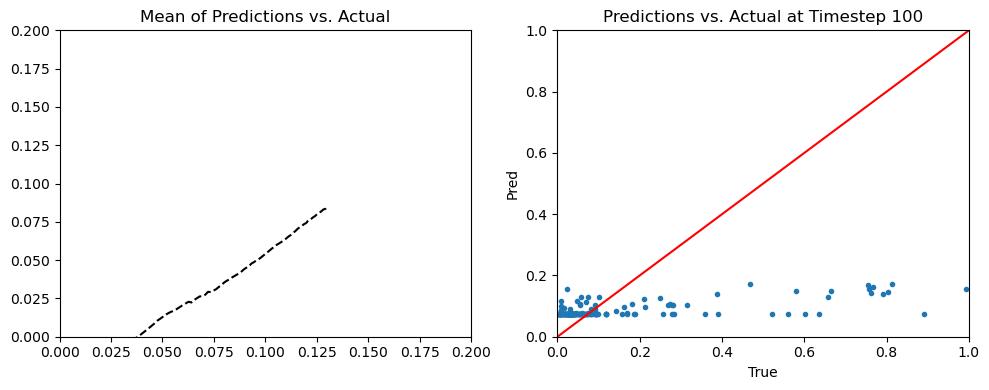

In [42]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(np.mean(y_test, axis=0), np.mean(y_test_pred, axis=0), 'k--')
plt.xlim([0,0.2]); plt.ylim([0,0.2])
plt.title('Mean of Predictions vs. Actual')
tstep = 100
plt.subplot(122)
plt.plot(y_test[:,tstep], y_test_pred[:,tstep], '.')
plt.xlabel('True'); plt.ylabel('Pred')
plt.xlim([0,1]); plt.ylim([0,1])
plt.axline([0,0], [1,1], color='r', linestyle='-')
plt.title(f'Predictions vs. Actual at Timestep {tstep}')
plt.tight_layout(); plt.show()

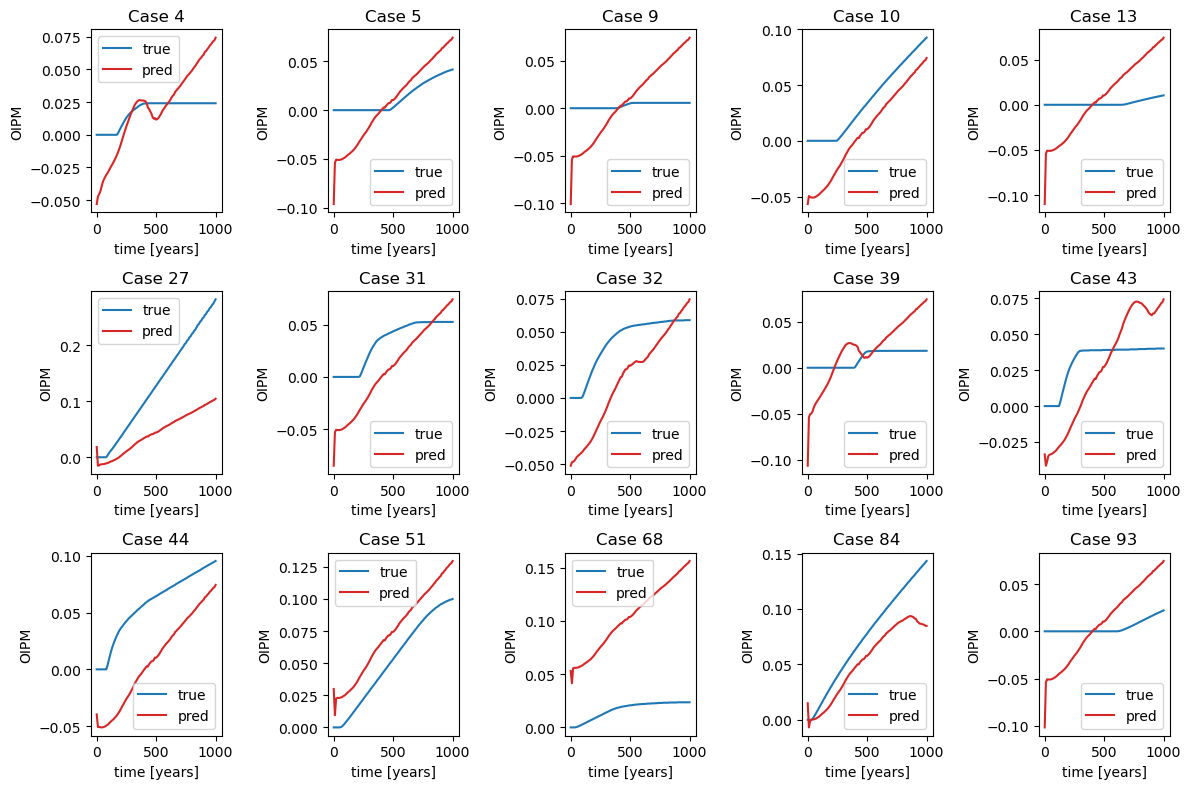

In [53]:
timesteps = np.linspace(0, 1000, num=101)
n_realizations = 15
k = np.sort(random.sample(range(100), n_realizations))

plt.figure(figsize=(12,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.plot(timesteps, y_test[k[i],:], 'tab:blue', label='true')
    plt.plot(timesteps, y_test_pred[k[i],:], 'tab:red', label='pred')
    plt.xlabel('time [years]'); plt.ylabel('OIPM')
    plt.title(f'Case {k[i]+1}'); plt.legend()
plt.tight_layout(); plt.show()

***
# END